In [2]:
import numpy as np
import json
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, DayLocator, MonthLocator

import sys
sys.path.append("../utils")

from importlib import reload
import utils
reload(utils)
from utils import load_config, evaluation_nt

# Load the configuration file
config = load_config('../config.yaml')

# load forecast interval
time_interval = config["time_interval"]
time_interval_start = config["time_interval_start"]

# start and end datatime for 5day-ahead forecasting
start_date = config["start_test"]
end_date = config["end_test"]

inpath_eac4_loc = config["path_eac4_loc"]            # longitude and latitude of EAC4 dataset
inpath_refer = config["path_refer"]
inpath_pred_list = {'ddnet': config["path_out_oper"]+"oper-{}.npy",
                    'cams': config["path_cams_oper"],
                    'convlstm': config["path_out_long"]+"pred-{}.npy"}

path_fig = config["path_figures"]

# longitude and latitude
loc = np.load(inpath_eac4_loc)
lon_mesh = loc['lon']
lat_mesh = loc['lat']

# two varables: 0. PM2.5 concentration
#               1. AOD550 value 
features = ['pm2p5', 'aod550']
titles = ['PM2.5', 'AOD550']
scale = [1e9, 1]
ylabels = ['RMSE ($ug/m3$)', 'RMSE']

# 3 model forecasts: 1. ddnet
#                      2. CAMS
#                      3. ConvLSTM
    
pred_list = ['ddnet', 'cams', 'convlstm']
labels = {'ddnet':'D-DNet({})',  
          'cams':'CAMS({})',
          'convlstm':'ConvLSTM({})'}
colors = {'ddnet':'C1', 
          'cams':'grey',
          'convlstm':'C0'}

In [3]:
#   paths for forecasts and references -- used for validation
start_date = datetime.strptime(start_date, '%Y-%m-%d %H:%M')
end_date = datetime.strptime(end_date, '%Y-%m-%d %H:%M') - timedelta(days=5)

inpath_pred_list_formated = {}
for key in pred_list:
    inpath_pred = inpath_pred_list[key].format(start_date.strftime("%Y%m%d%H"), {})
    if key == 'cams':
        inpath_pred = inpath_pred_list[key].format({})
        
    inpath_pred_list_formated[key] = inpath_pred

print(inpath_pred_list_formated)

# Generate datetime objects
date_list = []
current_date = start_date
while current_date <= end_date:
    date_list.append(current_date)
    current_date += timedelta(hours=time_interval)

{'ddnet': '/DATA/ddnet_demo/forecast_oper/start_2019010100/oper-{}.npy', 'cams': '/DATA/CAMS/cams_opf/cams-{}.npy', 'convlstm': '/DATA/ddnet_demo/forecast_long/start_2019010100/pred-{}.npy'}


# - Figure 2
### -------------------- RMSE & R ------------------------------

----------------------- PM2.5 forecasts -----------------------
cams  - rmse: mean=19.94 var=109.96
cams  - r: mean=0.70 var=0.02
convlstm  - rmse: mean=28.64 var=102.36
convlstm  - r: mean=0.48 var=0.01
ddnet  - rmse: mean=18.05 var=122.08
ddnet  - r: mean=0.73 var=0.02
saved to ../figures/metrics_oper_pm2p5.png


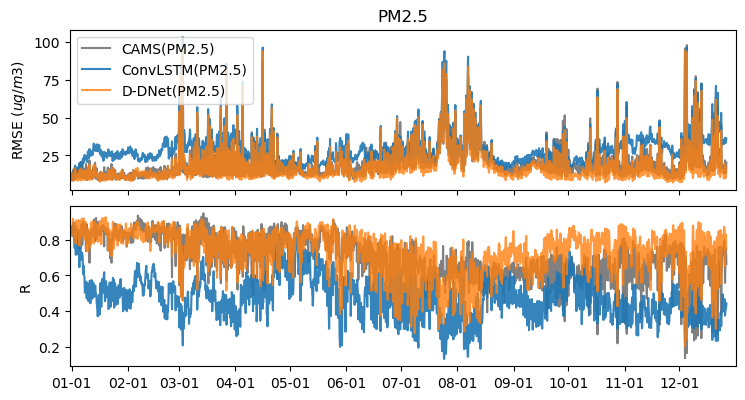

R > 0.20797310073378059, RMSE < 9.482519138250755e-08
----------------------- AOD550 forecasts -----------------------
cams  - rmse: mean=0.08 var=0.00
cams  - r: mean=0.85 var=0.00
convlstm  - rmse: mean=0.21 var=0.00
convlstm  - r: mean=0.50 var=0.01
ddnet  - rmse: mean=0.07 var=0.00
ddnet  - r: mean=0.87 var=0.00
saved to ../figures/metrics_oper_aod550.png


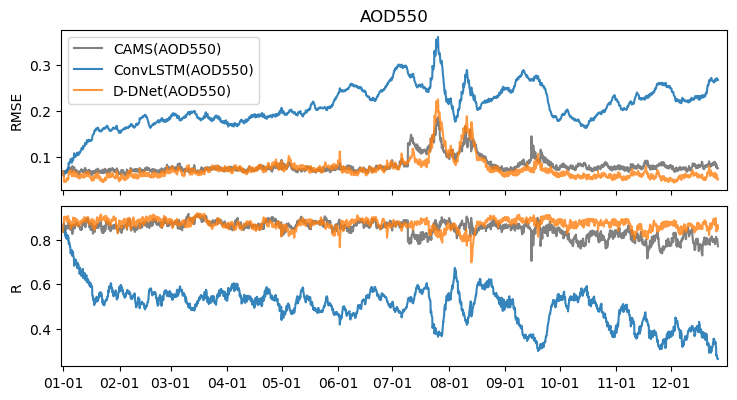

R > 0.6984675161401037, RMSE < 0.2256046253194045


In [8]:
# ------------------ evaluation: metrics 0 ------------------------
# index = 0      # index: 0 for PM2.5, 1 for AOD550 evaluation

# Figure 2
ifontsize = 10

# select evaluation results wanna display
pred_list = ['cams', 'convlstm', 'ddnet']
date_plot = [datetime.fromisoformat(str(date)) for date in date_list]

for index in [0, 1]:
    
    print(f"----------------------- {titles[index]} forecasts -----------------------")
    
    # load metrics dataset
    filename = "../results/metrics-{}.json".format(features[index])
    with open(filename, 'r') as json_file:
        metrics = json.load(json_file)
    
    figure_width_mm = 190
    figure_height_mm = 95
    # Convert mm to inches
    figure_width_inches = figure_width_mm / 25.4
    figure_height_inches = figure_height_mm / 25.4
    fig, ax = plt.subplots(2, 1, figsize=(figure_width_inches, figure_height_inches), sharex=True)
    
    for i in range(len(pred_list)):
        key = pred_list[i]
        RMSE = metrics[key]['RMSE']
        m = ax[0].plot(date_plot, np.array(RMSE)*scale[index], color=colors[key], label=labels[key].format(titles[index]), alpha = 1-0.1*i)
        
        R = metrics[key]['R']
        m = ax[1].plot(date_plot, R, color=colors[key], label=labels[key].format(titles[index]), alpha = 1-0.1*i)
        
        print(key,' - rmse:', f'mean={(np.array(RMSE)*scale[index]).mean():.2f}', f'var={(np.array(RMSE)*scale[index]).var():.2f}')
        print(key,' - r:', f'mean={(np.array(R)).mean():.2f}', f'var={(np.array(R)).var():.2f}')
    
    ax[0].set_title(titles[index])
    ax[0].set_ylabel(ylabels[index])
    ax[1].set_ylabel('R')
    
    ax[0].legend(loc=2, frameon=True, fontsize=ifontsize)
    
    plt.subplots_adjust(wspace=0.02, hspace=0.1, left=0.09, right=0.98, top=0.98, bottom=0.08)
    
    ax[1].set_xlim(datetime(2018,12,31,0), datetime(2019,12,31,23))
    
    # Adjust x-ticks distance and format
    ax[1].xaxis.set_major_locator(MonthLocator(interval=1))  # Set the tick interval to every 2 days
    ax[1].xaxis.set_major_formatter(DateFormatter("%m-%d"))  # Format the tick labels
    
    filename = path_fig + 'metrics_oper_{}.png'.format(features[index])
    fig.savefig(filename, dpi=300)
    print('saved to', filename)
    plt.show()
    
    print("R > {}, RMSE < {}".format(min(R), max(RMSE)))

# - Figure 3
#### ----------------- Cumulative Accuracy Profile (CAP) ----------------

In [10]:
# make a percentage comparison
def percent_count(R, r2_list):
    r2_array = np.array(R)
    total = r2_array.size

    percent_r2_list = []
    for r2_min in r2_list:
        r2_min_count = r2_array >= r2_min
        percent = r2_min_count.sum()/total
        percent_r2_list.append(percent)
        
    return percent_r2_list

----------------------- PM2.5 forecasts -----------------------
../figures/long-metrics_op_percent_pm2p5.png


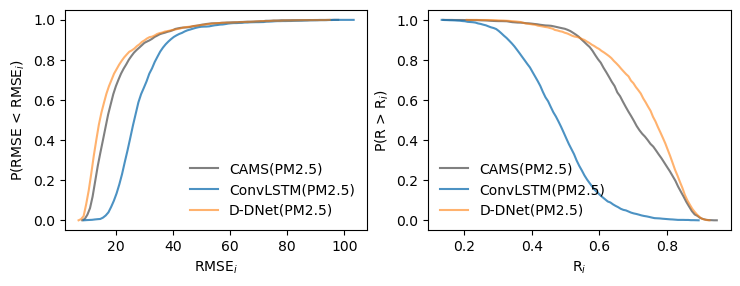

----------------------- AOD550 forecasts -----------------------
../figures/long-metrics_op_percent_aod550.png


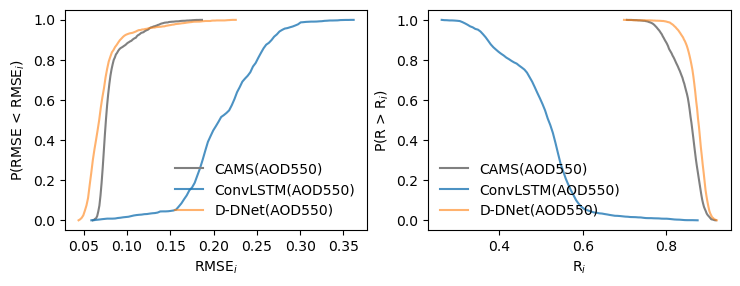

In [11]:
# ----------------- Cumulative Accuracy Profile (CAP) ----------------

for index in [0, 1]:
    
    print(f"----------------------- {titles[index]} forecasts -----------------------")
    
    # load metrics dataset
    filename = "../results/metrics-{}.json".format(features[index])
    with open(filename, 'r') as json_file:
        metrics = json.load(json_file)
    
    
    figure_width_mm = 190
    figure_height_mm = 70
    figure_width_inches = figure_width_mm / 25.4
    figure_height_inches = figure_height_mm / 25.4

    fig, ax = plt.subplots(1, 2, figsize=(figure_width_inches, figure_height_inches))
    
    for i in range(len(pred_list)):
        key = pred_list[i]
        RMSE = np.array(metrics[key]['RMSE'])*scale[index]
        rmse_list =  np.linspace(np.min(RMSE), np.max(RMSE), 100)
        percent_rmse = percent_count(RMSE, rmse_list)
        m = ax[0].plot(rmse_list, 1-np.array(percent_rmse), color=colors[key], label=labels[key].format(titles[index]), alpha = 1-0.2*i)
        
        R = metrics[key]['R']
        r2_list =  np.linspace(np.min(R), np.max(R), 100)
        percent_r2 = percent_count(R, r2_list)
        m = ax[1].plot(r2_list, percent_r2, color=colors[key], label=labels[key].format(titles[index]), alpha = 1-0.2*i)
    
    ax[0].legend(loc=4, frameon=False, fontsize=ifontsize)  
    ax[1].legend(loc=3, frameon=False, fontsize=ifontsize)  
    
    ax[0].set_ylabel('P(RMSE < RMSE$_i$)')
    ax[0].set_xlabel('RMSE$_i$')
    ax[1].set_ylabel('P(R > R$_i$)')
    ax[1].set_xlabel('R$_i$')
    
    
    plt.subplots_adjust(wspace=0.2, hspace=0.1, left=0.09, right=0.98, top=0.98, bottom=0.18)
    
    filename = path_fig+ 'long-metrics_op_percent_{}.png'.format(features[index])
    print(filename)
    fig.savefig(filename, dpi=300)
    
    plt.show()

# - Figure 4 & 5
### ------------------------- PM2.5 Concentration and AOD550 values -------------------------

In [13]:
import cartopy.crs as ccrs

# ilabel = 'PM2.5 concentration \n (ug/m3)'  # 'Temperature (K)'
# figure 1: reference

def fig_with_map_ax(ax, lon_mesh, lat_mesh, data, vmin=0.0, vmax=1.0, ititle='', ilabel='',icmap='YlOrRd'):        
    
    ax.set_global()
    ax.coastlines(color='k')
    
    im = ax.pcolormesh(lon_mesh-180, lat_mesh, data, cmap=icmap, vmin=vmin, vmax=vmax)
    
    return im

----------------------- PM2.5 forecasts -----------------------
1 ../results/ddnet-2019020109.npy
4 ../results/cams-2019020109.npy
7 ../results/refer-2019020109.npy
2 ../results/ddnet-2019060109.npy
5 ../results/cams-2019060109.npy
8 ../results/refer-2019060109.npy
3 ../results/ddnet-2019100109.npy
6 ../results/cams-2019100109.npy
9 ../results/refer-2019100109.npy
../figures/opf_compare_pm25-1.png


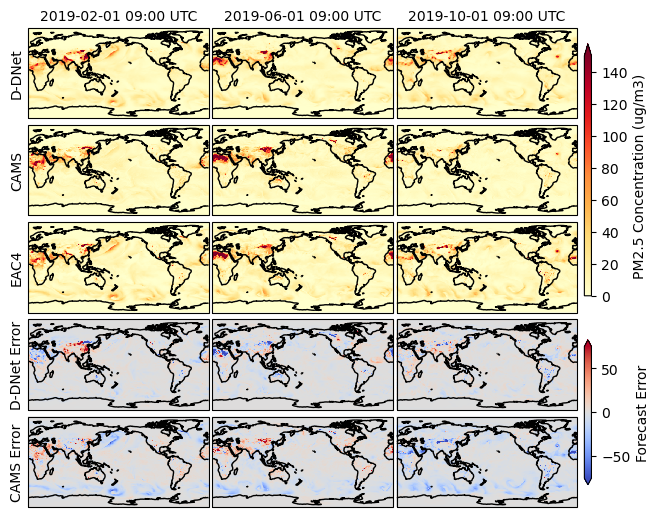

----------------------- AOD550 forecasts -----------------------
1 ../results/ddnet-2019020109.npy
4 ../results/cams-2019020109.npy
7 ../results/refer-2019020109.npy
2 ../results/ddnet-2019060109.npy
5 ../results/cams-2019060109.npy
8 ../results/refer-2019060109.npy
3 ../results/ddnet-2019100109.npy
6 ../results/cams-2019100109.npy
9 ../results/refer-2019100109.npy
../figures/opf_compare_aod550-1.png


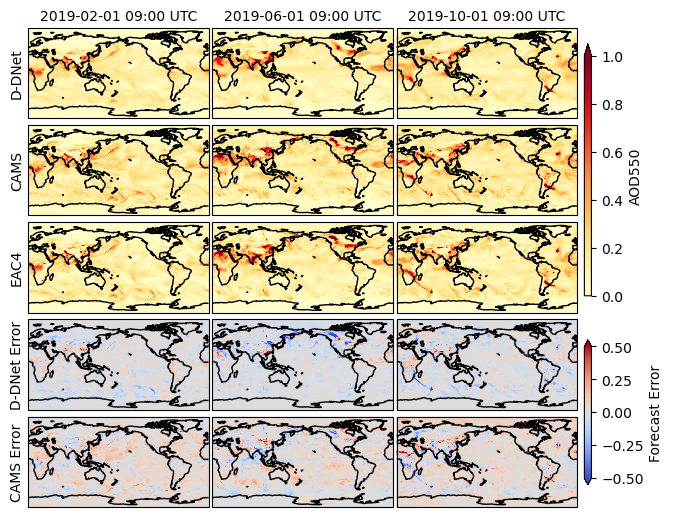

In [26]:
# visualize PM2.5 and AOD550

# RMSE and R over CAMS operational forecasting (initial at 00 and 12 UCT)

# ------------------ evaluation: metrics 0 ------------------------

date_visual = [datetime(2019, 2, 1, 9, 0), datetime(2019, 6, 1, 9, 0), datetime(2019, 10, 1, 9, 0)]

path_list = ['../results/ddnet-{}.npy', 
             '../results/cams-{}.npy',
             '../results/refer-{}.npy']

label_list = ['D-DNet', 'CAMS', 'EAC4', 'D-DNet Error', 'CAMS Error']
cbar_label = ['PM2.5 Concentration (ug/m3)',  'AOD550']
keys = ['pm25', 'aod550']
# scale
scale = [1e9, 1]
# maximum value for visual
VMAX = [150, 1]

# index: 0 for pm2.5 & 1 aor AOD550
for index in [0,1]:
    
    print(f"----------------------- {titles[index]} forecasts -----------------------")
    
    #  viusalization of forecast results
    # a large image with forecasting results at 3 datetimes at [0, 1, 2] columns
    # suing D-DNet, CAMS, EAC4 at [0, 1, 2] rows 
    # put matrices on the bottoms
    # PM2.5 and AOD550 at two different figures
    
    # 1/4 page figure = 95 mm x 115 mm
    # Full page = 190 mm x 230 mm
    figure_width_mm = 180
    figure_height_mm = 160
    # Convert mm to inches
    figure_width_inches = figure_width_mm / 25.4
    figure_height_inches = figure_height_mm / 25.4
    
    fig = plt.figure(figsize=(figure_width_inches, figure_height_inches))
    n_column = 3
    n_row = 5
    
    # Define a list to store the subplots for the colorbar
    colorbar_axes = []
    
    # loop over datetimes
    for i_column in range(n_column):
        idate = date_visual[i_column]
        # loop over different datasets
        for i_row in range(n_row):
            if i_row < 3:
                i_path = path_list[i_row]
                filename = i_path.format(idate.strftime('%Y%m%d%H'))
                print(i_row*n_column+i_column+1, filename)
                value = np.load(filename)[...,index].copy()*scale[index]
                
                ax = fig.add_subplot(n_row, n_column, i_row*n_column+i_column+1, projection=ccrs.PlateCarree(central_longitude=180))   
                im = fig_with_map_ax(ax, lon_mesh, lat_mesh, value, vmax=VMAX[index]) 
                if i_row == 0:
                    pred = value.copy()
                if i_row == 1:
                    cams = value.copy()
                if i_row == 2:
                    refer = value.copy() 
            else:
                ax = fig.add_subplot(n_row, n_column, i_row*n_column+i_column+1, projection=ccrs.PlateCarree(central_longitude=180))
                if i_row == 3:
                    im_err = fig_with_map_ax(ax, lon_mesh, lat_mesh, pred-refer, icmap='coolwarm', vmin=-1*VMAX[index]*0.5, vmax=VMAX[index]*0.5)
                if i_row == 4:
                    im_err = fig_with_map_ax(ax, lon_mesh, lat_mesh, cams-refer, icmap='coolwarm', vmin=-1*VMAX[index]*0.5, vmax=VMAX[index]*0.5)
                
            # set vertival labal
            if i_column == 0:
                ax.text(-0.1, 0.5, label_list[i_row], rotation='vertical', transform=ax.transAxes, va='center')
                
            # set datetime label
            if i_row == 0:
                ax.text(0.5, 1.05, idate.strftime('%Y-%m-%d %H:%M UTC'), transform=ax.transAxes, ha='center', va='bottom')
    
    subplot_spacing = 0.02
    fig.subplots_adjust(hspace=subplot_spacing/2, wspace=subplot_spacing)
    
    # Create a separate subplot for the colorbar
    cax_position = [0.91, 0.45, 0.01, 0.4]
    cax = fig.add_axes(cax_position)
    cbar = plt.colorbar(im, cax=cax, label=cbar_label[index], orientation='vertical', extend='max', pad=0.01)
    
    # Create a separate subplot for the colorbar
    cax_position = [0.91, 0.15, 0.01, 0.23]
    cax = fig.add_axes(cax_position)
    cbar = plt.colorbar(im_err, cax=cax, label='Forecast Error', orientation='vertical', extend='both', pad=0.01)
    
    filename = path_fig+'opf_compare_'+keys[index]+'-1.png'
    print(filename)
    # plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()